# CV Lab 2
## Chloë Smith - 1877342

In [1]:
# imports
import cv2
import numpy as np
import scipy.stats as ss
from sklearn.cluster import KMeans
import skimage
from skimage.color import rgb2gray
from skimage import img_as_float
from skimage.feature import local_binary_pattern
import imageio
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

import os
import math

In [2]:
def load_images_from_folder(folder):
    images = []
    masks = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            #print(filename)
            if filename.split("-")[0] == "image":
                images.append(img)
            else:
                masks.append(img)
    return images, masks

In [3]:
# read in images and masks
images, masks = load_images_from_folder("images")

# choose ONE image to work with for sections 4, 5, 6
image = images[0]
mask = masks[0]

gray_image = rgb2gray(image)
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = img_as_float(image)

In [4]:
def min_max_contrast_stretch(image, int_type=False):
    stretched_img = image
    if int_type == False:
        for i in range(3):
            minimum = min([min(p) for p in stretched_img[:, :, i]])
            maximum = max([max(p) for p in stretched_img[:, :, i]])
            for y in range(stretched_img.shape[0]):
                for x in range(stretched_img.shape[1]):
                    stretched_img[y, x, i] = (stretched_img[y, x, i] - minimum) / (maximum - minimum)
    elif int_type == True:
        for i in range(3):
            minimum = min([min(p) for p in stretched_img[:, :, i]])
            maximum = max([max(p) for p in stretched_img[:, :, i]])
            for y in range(stretched_img.shape[0]):
                for x in range(stretched_img.shape[1]):
                    stretched_img[y, x, i] = (stretched_img[y, x, i] - minimum) / (maximum - minimum) * 255
                    
    return stretched_img

## Section 1: Additional Filters

1. Create the Gaussian filter using the function shown in Equation 1. Note $\sigma$ is a hyper-parameter that we set, and depends on the size of your kernel.

In [5]:
def gaussian_filter(k, sigma):
    centre = k // 2
    
    f = lambda x, y: 1/(2*math.pi*math.pow(sigma, 2)) * math.exp(-(math.pow(x - centre, 2) + math.pow(y - centre, 2))/(2*math.pow(sigma, 2)))
    g = np.vectorize(f)
    K = np.fromfunction(g, (k, k))
    
    return K    

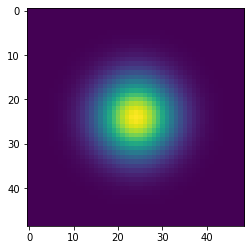

In [6]:
# test gaussian_filter
k = 49
sigma = 6
K_gaussian = gaussian_filter(k, sigma)
#print(K_gaussian)
plt.imshow(K_gaussian)

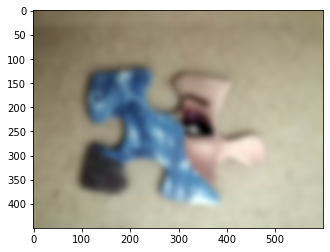

In [7]:
# convolve and display contrast stretched image
gaussian_img = cv2.filter2D(image, -1, K_gaussian)
plt.imshow(min_max_contrast_stretch(gaussian_img))

2. Create the LoG filter using the function shown in Equation 2.

In [8]:
def LoG_filter(k, sigma):
    centre = k // 2
    
    f = lambda x, y: -1/(math.pi*math.pow(sigma, 4)) * (1 - (math.pow(x - centre, 2) + math.pow(y - centre, 2))/(2*math.pow(sigma, 2))) * math.exp(-(math.pow(x - centre, 2) + math.pow(y - centre, 2))/(2*math.pow(sigma, 2)))
    g = np.vectorize(f)
    K = np.fromfunction(g, (k, k))
    
    return K

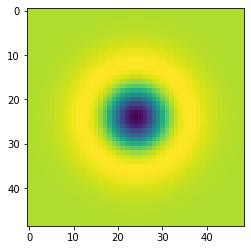

In [9]:
# test LoG_filter
k = 49
sigma = 6
K_LoG = LoG_filter(k, sigma)
#print(K_LoG)
plt.imshow(K_LoG)

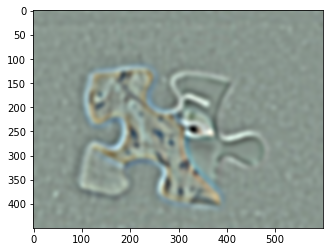

In [10]:
# convolve and display contrast stretched image
LoG_img = cv2.filter2D(image, -1, K_LoG)
plt.imshow(min_max_contrast_stretch(LoG_img))

3. Create the DoG filter using the function shown in Equation 3. Note $K > 1.0$ is another hyper-parameter used to enforce the constraint that the subtracted Gaussian have a larger variance than the first.

In [11]:
def DoG_filter(k, sigma, K):
    if K <= 1.0:
        print("K must be < 1.0")
        return
    
    centre = k // 2
    
    f = lambda x, y: (1/(2*math.pi*math.pow(sigma, 2))*math.exp(-(math.pow(x - centre, 2)+math.pow(y - centre, 2))/(2*math.pow(sigma, 2)))) - (1/(2*math.pi*math.pow(K*sigma, 2))*math.exp(-(math.pow(x - centre, 2) + math.pow(y - centre, 2))/(2*math.pow(K*sigma, 2))))
    g = np.vectorize(f)
    filt = np.fromfunction(g, (k, k))
    
    return filt

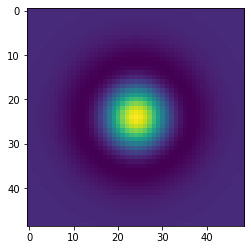

In [12]:
# test DoG_filter
k = 49
sigma = 6
K = 1.1
K_DoG = DoG_filter(k, sigma, K)
plt.imshow(K_DoG)

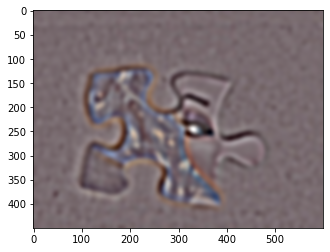

In [13]:
# convolve and display contrast stretched image
DoG_img = cv2.filter2D(image, -1, K_DoG)
plt.imshow(min_max_contrast_stretch(DoG_img))

## Section 2: Gaussian Edge and Bar Filters - The RFS/MR8 Filter Banks

A two-dimensional Gaussian filter has three hyper-parameters $\theta$ (the orientation or rotation of the filter), $\sigma_x$ and $\sigma_y$ (the scale or variance. The two-dimensional Gaussian function $g$ is shown in Equation 4 as the product of two 1D Gaussian functions $f$. The corresponding Gaussian edge and bar filters are derived from the first and second derivatives of $g$ with respect to $y'$ (we are **not** using $y'$ here to denote the derivative of $y$). It should be noted that $g$ in Equation 4 simplifies to Equation 1 when $\sigma_x = \sigma_y$ and $\theta = 0$.

$g(x, y, \theta, \sigma_x, \sigma_y) = f(x'(x, y, \theta), \sigma_x) * f(y'(x, y, \theta), \sigma_y)$

$x'(x, y, \theta) = x cos(\theta) - y sin(\theta)$

$y'(x, y, \theta) = x sin(\theta) + y cos(\theta)$

$f(x, \sigma) = \frac{1}{\sqrt{2\pi\sigma}}exp(-\frac{x^2}{2\sigma^2})$

1. Create a function which accepts the three parameters corresponding to the three hyper-parameters of the two-dimensional Gaussian described above $(\theta, \sigma_x, \sigma_y)$, as well as the size of your filter and if the filter is the edge (first derivative) or bar (second derivative) filter. This function should create the filer using the appropriate derivative of $g$ (from Equation 4) and return this filter.

In [14]:
def f_func(x, sigma):
    return 1/(2*math.pi*sigma)*math.exp(-math.pow(x, 2)/(2*math.pow(sigma, 2)))

def gaussian_filter_2d(theta, sigma_x, sigma_y, k, bar = False):
    centre = k // 2
    x_prime = lambda x, y: (x * math.cos(theta)) - (y * math.sin(theta))
    y_prime = lambda x, y: (x * math.sin(theta)) + (y * math.cos(theta))
    
    if bar == False:
        # return edge filter
        f = lambda x, y: f_func(x_prime(x - centre, y - centre), sigma_x) * f_func(y_prime(x - centre, y - centre), sigma_y) * -y_prime(x - centre, y - centre)/math.pow(sigma_y, 2)
        g = np.vectorize(f)
        K = np.fromfunction(g, (k, k))
    else:
        # return bar filter
        f = lambda x, y: f_func(x_prime(x - centre, y - centre), sigma_x) * f_func(y_prime(x - centre, y - centre), sigma_y) * (math.pow(y_prime(x - centre, y - centre), 2) - math.pow(sigma_y, 2))/math.pow(sigma_y, 4)
        g = np.vectorize(f)
        K = np.fromfunction(g, (k, k))
    
    return K

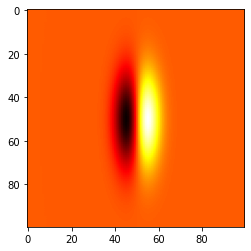

In [15]:
# test gaussian_filter_2d
# edge filter
theta = math.pi
sigma_x = 15
sigma_y = 5
k = 100
K_gauss_2d = gaussian_filter_2d(theta, sigma_x, sigma_y, k, bar = False)
plt.imshow(K_gauss_2d, cmap='hot')

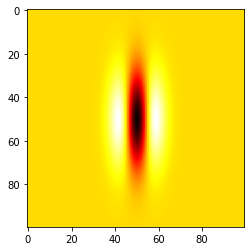

In [16]:
# bar filter
theta = math.pi
sigma_x = 15
sigma_y = 5
k = 100
K_gauss_2d = gaussian_filter_2d(theta, sigma_x, sigma_y, k, bar = True)
plt.imshow(K_gauss_2d, cmap='hot')

2. We will now create the RFS (Root Filter Set) bank from which the rotationally invariant MR8 bank is derived. The 38 filters we use in the RFS bank are a Gaussian and a LoG, both with $\sigma^2 = 10$ (these filters have rotational symmetry) and rotated sets of Gaussian edge and bar filters. These sets of edge and bar filters will be constructed using the following permutations of hyper-parameters:

<center>
    $$(\sigma_x, \sigma_y) \in \{(3, 1), (6, 2), (12, 4)\} \\
    
    \theta \in \{0, \frac{1}{6}\pi, \frac{2}{6}\pi, \frac{3}{6}\pi, \frac{4}{6}\pi, \frac{5}{6}\pi \} \\
    
    size = (49, 49)
    $$
</center>

Every value for one hyper-parameter needs to be used with every other value for all the other hyper-parameters. So for example $(\sigma_x, \sigma_y) = (3, 1)$ needs to be used with all the values for $\theta$ to generate a single rotated edge or bar filter set. Since we have 3 $(\sigma_x, \sigma_y)$ parameters, 6 $\theta$ parameters, and this process needs to be repeared for the first and second derivatives of $g$ with respect to $y'$, this results in $3 * 6 * 2 = 36$ Gaussian edge and bar filters. Combines with the Gaussian and LoG filters, this gives us our total of 38 RFS filters. An example of our filter bank can be seen in Figure 2. Apply the RFS filter bank to your image.

In [17]:
# generate the 38 filters
def RFS_bank():
    RFS = []

    sigma_x_y = [[3, 1],
                [6, 2],
                [12, 4]]
    k = 49
    for i in range(3):
        sigma_x = sigma_x_y[i][0]
        sigma_y = sigma_x_y[i][1]
        for j in range(6):
            theta = j * math.pi/6
            RFS.append(gaussian_filter_2d(theta, sigma_x, sigma_y, k, bar = False))
    for i in range(3):
        sigma_x = sigma_x_y[i][0]
        sigma_y = sigma_x_y[i][1]
        for j in range(6):
            theta = j * math.pi/6
            RFS.append(gaussian_filter_2d(theta, sigma_x, sigma_y, k, bar = True))

    sigma = math.sqrt(10)
    RFS.append(gaussian_filter(k, sigma))
    RFS.append(LoG_filter(k, sigma))
    
    return RFS

RFS Filter Bank:


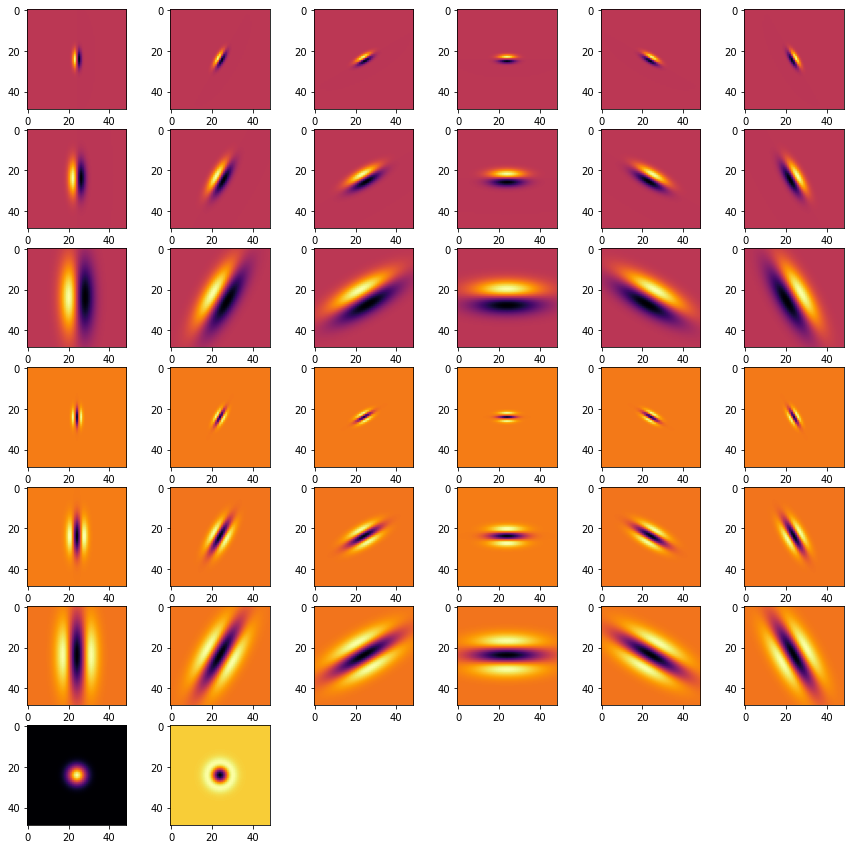

In [18]:
# display the 38 filters
RFS = RFS_bank()

print("RFS Filter Bank:")
plt.figure(figsize=(15,15))
for i in range(len(RFS)):
    plt.subplot(7, 6, 1+i)
    plt.imshow(RFS[i], cmap='inferno')

In [19]:
# apply to the image
img_RFS = []

for kernel in RFS:
    img_RFS.append(cv2.filter2D(image, -1, kernel))

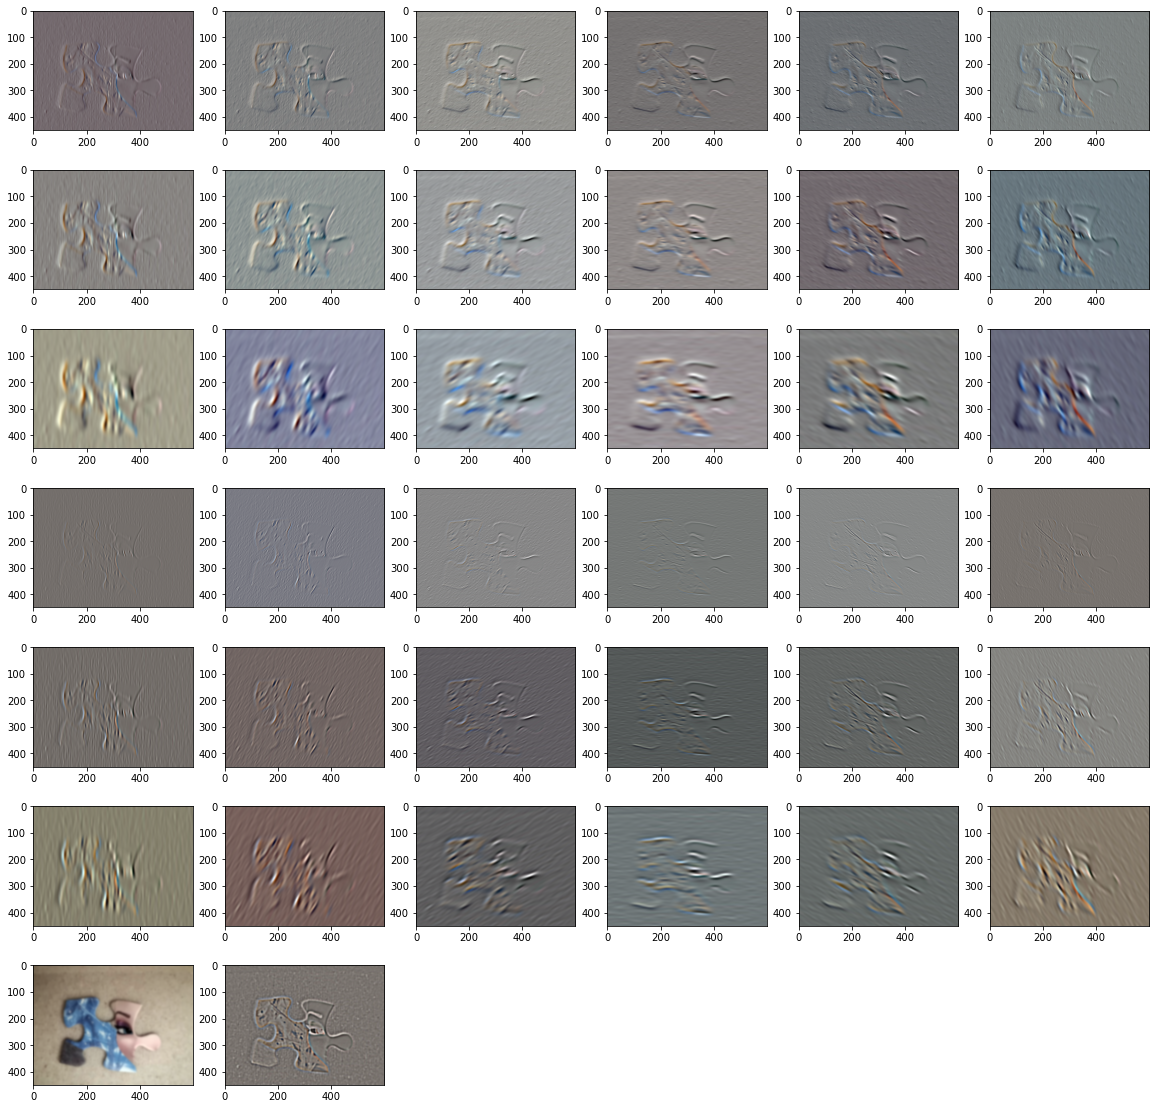

In [20]:
# display filter responses
plt.figure(figsize=(20,20))
for i in range(38):
    plt.subplot(7, 6, 1+i)
    plt.imshow(min_max_contrast_stretch(img_RFS[i]))

3. The MR8 rotationally invariant features are constructed from the maximal activations of the similar but rotated filters in the RFS bank (each row in Figure 2). This results in 8 total features instead of 38 for each pixel after being applied to an image. So for every $(\sigma_x, \sigma_y)$ of the edge and bar filters separately, find the maximal $\sigma^*$ value which corresponds to the rotated filter with the largest activation and keep only this $\theta's$ activation value. Do this for each pixel individually. Use the RFS hyper-parameters for each pixel, and let $\alpha_\theta$ be the activation of the current pixel for the different rotated filters corresponding to $\theta$:

<center>
    $$(\sigma_x, \sigma_y) \in \{(3, 1), (6, 2), (12, 4)\} \\
    
    \theta^* = argmax_{\theta \in \{\frac{0}{6}\pi,...,\frac{5}{6}\pi\}} \alpha_\theta \\
    
    size = (49, 49)
    
    $$
</center>

In [21]:
def RFS_to_MR8(RFS_bank, image):
    # only for 3-channel images at the moment
    assert len(RFS_bank) == 38
    
    MR8 = []
    for n in range(6):
        responses = []
        for k in range(n, n+6):
            responses.append(cv2.filter2D(image, -1, RFS_bank[k]))
        response = responses[0]
        
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                res = []
                for idx in range(6):
                    res.append(responses[idx][i][j])
                m_res = np.max(res, axis=0)
                response[i][j] = m_res
                    
        MR8.append(response)
        
    MR8.append(cv2.filter2D(image, -1, RFS_bank[36]))
    MR8.append(cv2.filter2D(image, -1, RFS_bank[37]))
    
    assert len(MR8) == 8
    return MR8

In [22]:
# test RFS_to_MR8
img_MR8 = RFS_to_MR8(RFS, image)

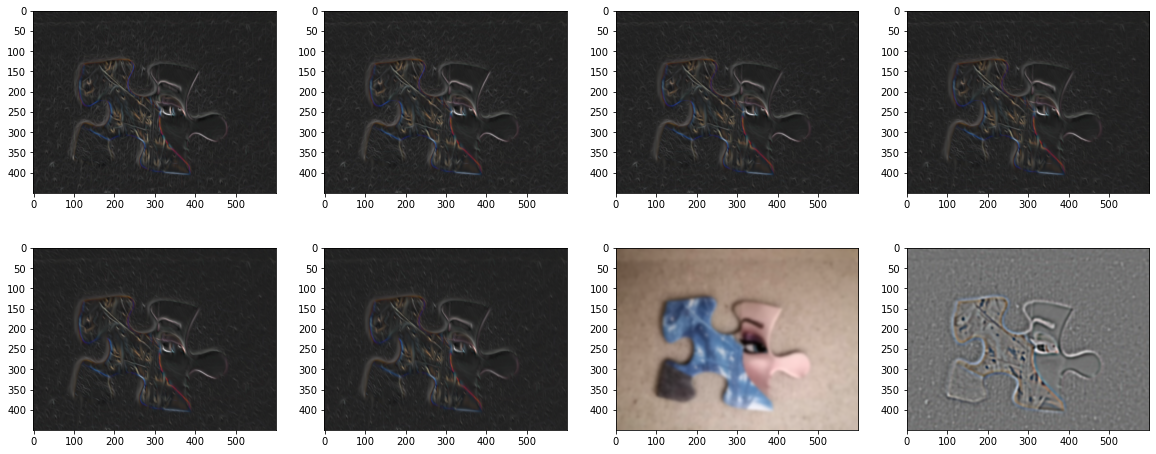

In [23]:
# display results of MR8
plt.figure(figsize=(20,8))
for i in range(8):
    plt.subplot(2, 4, 1+i)
    plt.imshow(skimage.exposure.rescale_intensity(img_MR8[i], out_range=(0,1)))

## Section 3: Local Binary Patterns and Haar Filters

1. Implement the local binary pattern filter and apply it to your training image. Use $radius = \{4, 8, 16, 24, 32\}$ with 12 points.

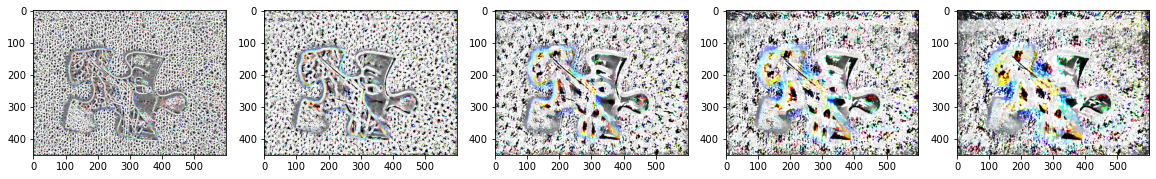

In [24]:
radius = [4, 8, 16, 24, 32]
n_points = 12

lbp = []
for r in radius:
    out = np.zeros(image.shape)
    for c in range(3):
        out[:,:,c] = local_binary_pattern(image[:,:,c], n_points, r, 'uniform')
    lbp.append(out)
    
    

plt.figure(figsize=(20,8))
for i in range(len(radius)):
    plt.subplot(1, 5, 1+i)
    plt.imshow(min_max_contrast_stretch(lbp[i]))

2. Calculate the three integral images for each channel of your original RGB image.

In [25]:
def integral_img(image, channels=3):
    temp = []
    for c in range(channels):
        integral = np.zeros((image.shape[0], image.shape[1]))
        integral[0][0] = image[0][0][c]
        for i in range(1, image.shape[0]):
            integral[i][0] = integral[i - 1][0] + image[i][0][c]
            for j in range(1, image.shape[1]):
                integral[0][j] = integral[0][j - 1] + image[0][j][c]
        for i in range(1, image.shape[0]):
            for j in range(1, image.shape[1]):
                integral[i][j] = image[i][j][c] + integral[i - 1][j] + integral[i][j - 1] - integral[i - 1][j - 1]
        temp.append(integral)
    out = np.zeros(image.shape)
    for c in range(channels):
        out[:,:,c] = temp[c]
        
    return out, temp

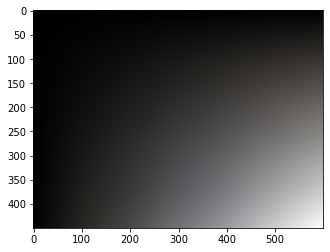

In [26]:
# test integral_img
int_img, rev = integral_img(image)
#print(int_img[:,:,0])
#print(rev[0])
plt.imshow(min_max_contrast_stretch(int_img))

3. Apply a checkered Haar filter like the one shown in Figure 3 to your image using your integral images. So the top left and bottom right quadrants are 1s and the top right and bottom left quadrants are -1s in your filter. Use filter sizes = {4, 8, 16)

In [27]:
def haar_filter(k):
    K = np.full((k, k), -1)
    for i in range(k // 2):
        for j in range(k // 2):
            K[i][j] = 1
            K[i + (k // 2)][j + (k // 2)] = 1
    return K

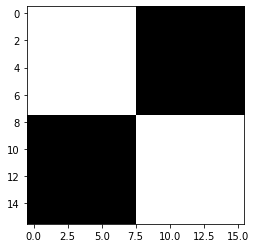

In [28]:
# test haar_filter
size = [4, 8, 16]
K_haar = []
for s in size:
    K_haar.append(haar_filter(s))
    
plt.imshow(K_haar[2], cmap='gray')

In [29]:
# apply Haar filter to image
def convolve_haar(image, k, int_img=True, channels=3):
    if int_img == False:
        img = integral_image(image, channels)
    else:
        img = image
        
    K = haar_filter(k)
    
    # rotate filter 180 degrees
    K = np.rot90(K, k=2)
    k_dim = np.shape(K)
    k_off = k_dim[0] // 2
    
    # padding
    if np.shape(np.shape(img))[0] == 2:
        temp = np.empty([np.shape(img)[0], np.shape(img)[1], 1])
        temp[:, :, 0] = img
        img = temp
        
    dim = np.shape(img)
    p_h = math.floor((k_dim[0] - 1) / 2)
    p_w = math.floor((k_dim[1] - 1) / 2)
    
    pad_img = np.pad(img, ((p_h,p_h), (p_w,p_w), (0,0)), 'constant')
    
    # convolution
    temp = np.shape(pad_img)
    out_dim = np.array([temp[0] - k_dim[0] + 1,
                        temp[1] - k_dim[1] + 1,
                        dim[2]])
    out = np.zeros(out_dim)
    
    in_dim = np.shape(pad_img)
    
    # for each channel
    for i in range(dim[2]):
        curr_y = out_y = 0
        while curr_y <= in_dim[0] - k_dim[0]:
            curr_x = out_x = 0
            while curr_x <= in_dim[1] - k_dim[0]:
                filt_val = (K[0,0]*(pad_img[curr_y+k_off-1, curr_x+k_off-1, i] + pad_img[curr_y, curr_x, i] - pad_img[curr_y+k_off-1, curr_x, i] - pad_img[curr_y, curr_x+k_off-1, i])) + (
                    K[k_off,0]*(pad_img[curr_y+k_dim[0]-1, curr_x+k_off-1, i] + pad_img[curr_y+k_off, curr_x, i] - pad_img[curr_y+k_dim[0]-1, curr_x, i] - pad_img[curr_y+k_off, curr_x+k_off-1, i])) + (
                    K[0,k_off]*(pad_img[curr_y+k_off-1, curr_x+k_dim[0]-1, i] + pad_img[curr_y, curr_x+k_off, i] - pad_img[curr_y+k_off-1, curr_x+k_off, i] - pad_img[curr_y, curr_x+k_dim[0]-1, i])) + (
                    K[k_off,k_off]*(pad_img[curr_y+k_dim[0]-1, curr_x+k_dim[0]-1, i] + pad_img[curr_y+k_off, curr_x+k_off, i] - pad_img[curr_y+k_dim[0]-1, curr_x+k_off, i] - pad_img[curr_y+k_off, curr_x+k_dim[0]-1, i]))
                out[out_y, out_x, i] = filt_val
                curr_x += 1
                out_x += 1
            curr_y += 1
            out_y += 1
            
    return out

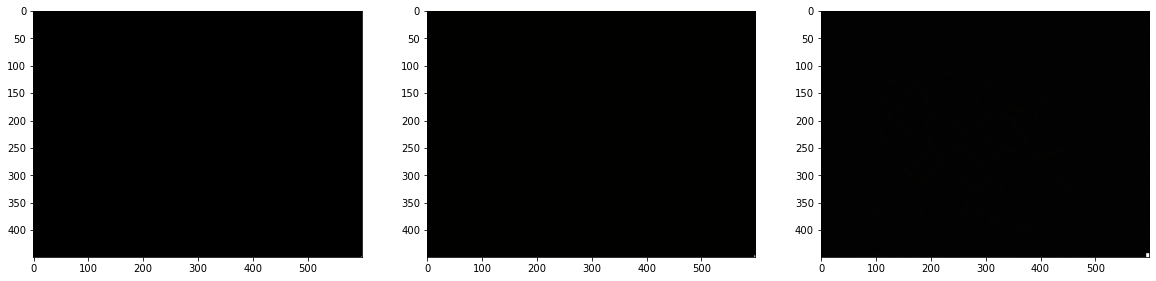

In [30]:
# test Haar filter on image
img_haar = []
for s in size:
    img_haar.append(convolve_haar(int_img, s))
    
plt.figure(figsize=(20,8))
for i in range(len(size)):
    plt.subplot(1, 3, 1+i)
    plt.imshow(min_max_contrast_stretch(img_haar[i]))
    
# images come out black but printing different pixel values shows *something* happened. Not sure why contrast stretching does nothing here.

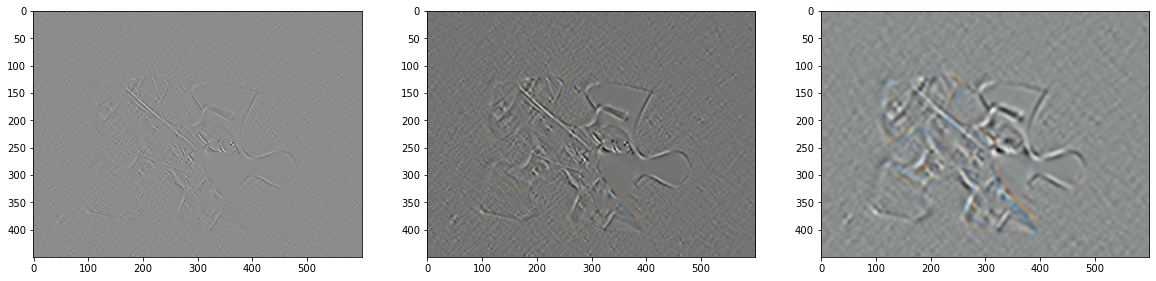

In [31]:
# use cv2.filter2D for responses for later questions
img_haar = []
for i in range(len(size)):
    img_haar.append(cv2.filter2D(image, -1, K_haar[i]))
    
plt.figure(figsize=(20,8))
for i in range(len(size)):
    plt.subplot(1, 3, 1+i)
    plt.imshow(min_max_contrast_stretch(img_haar[i]))

## Sections 4: Textons and Classification

1. Apply all of the feature extraction methods above to your image. Using the results, as well as the RGB, HSV and outputs of the Prewitt and Laplace filters, use the K-Means clustering algorithm to cluster your pixels. Use 4 clusters.

### Applying Prewitt and Laplace filters:

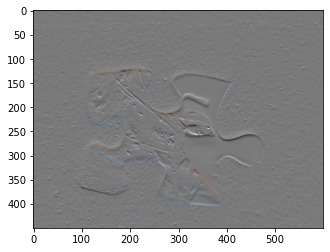

In [32]:
# Vertical Prewitt
K = np.array([[1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]])

v_prewitt = cv2.filter2D(image, -1, K)
plt.imshow(min_max_contrast_stretch(v_prewitt))

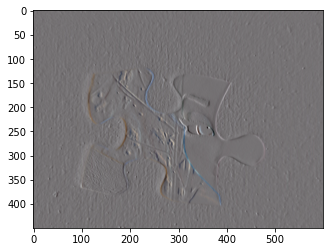

In [33]:
# Horizontal Prewitt
K = np.array([[1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]])

h_prewitt = cv2.filter2D(image, -1, K)
plt.imshow(min_max_contrast_stretch(h_prewitt))

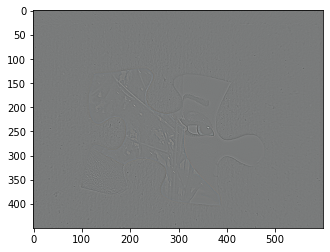

In [34]:
# Laplacian
K = np.array([[0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]])

laplacian = cv2.filter2D(image, -1, K)
plt.imshow(min_max_contrast_stretch(laplacian))

In [35]:
# concatenate all responses
img_all_features = image
img_all_features = np.concatenate((img_all_features, hsv_image), axis=2)
for res in img_RFS:
    img_all_features = np.concatenate((img_all_features, res), axis=2)
for res in img_MR8:
    img_all_features = np.concatenate((img_all_features, res), axis=2)
for res in lbp:
    img_all_features = np.concatenate((img_all_features, res), axis=2)
for res in img_haar:
    img_all_features = np.concatenate((img_all_features, res), axis=2)
print(img_all_features.shape)

(450, 600, 168)


In [37]:
# k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(img_all_features.reshape(-1, img_all_features.shape[-1]))

2. Replace the pixels of your image with their corresponding centroid from Question 4.1 and display this image. An example of this can be seen in Figure 4.

In [40]:
# test kmeans
#print(kmeans.labels_.shape)
#print(kmeans.cluster_centers_)

(270000,)


In [44]:
kmeans_img = gray_image
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        kmeans_img[i][j] = kmeans.predict(img_all_features[i][j].reshape(1, -1))

(450, 600)


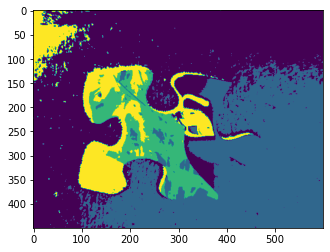

In [45]:
# display clustered image
print(kmeans_img.shape)
plt.imshow(kmeans_img)

3. Train a background classifier on your current set of features (all features mentioned in Question 4.1 including the texton values). Calculate the accuracy of this model.

In [47]:
# add kmeans clustering to features
temp = np.empty([np.shape(kmeans_img)[0], np.shape(kmeans_img)[1], 1])
temp[:, :, 0] = kmeans_img
kmeans_img = temp
img_with_textons = np.concatenate((img_all_features, kmeans_img), axis=2)
print(img_with_textons.shape)

In [48]:
# need to use mask to extract only pixels from background in image
gray_mask = rgb2gray(mask)
gray_mask = gray_mask*255

not_puzzle = gray_mask < 128
puzzle = gray_mask >= 128

# also convert mask to binary values
gray_mask[not_puzzle] = 0
gray_mask[puzzle] = 1

bkgrd_pixels = img_with_textons[not_puzzle,:]
print(bkgrd_pixels.shape)

(209134, 169)


In [49]:
# train classifier
# i.e., calculate mean and covariance
mean = np.empty(169)
cov = np.zeros((169,169))

mean = np.mean(bkgrd_pixels, axis=0)
cov = np.cov(bkgrd_pixels.T)

print(mean.shape)
print(cov.shape)

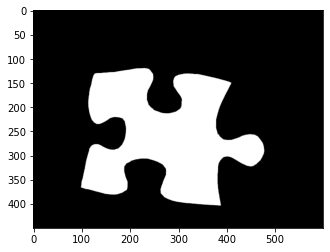

In [53]:
# display mask for comparison
plt.imshow(mask, cmap='gray')

Accuracy: 90.817778 percent
Confusion Matrix:
[[206030   3104]
 [ 21688  39178]]


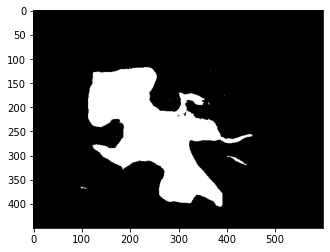

In [52]:
# test accuracy on training image
results = ss.multivariate_normal.pdf(img_with_textons, mean, cov, allow_singular=True)

theta = 0.01
predicted_mask = results < theta
predicted_mask = np.reshape(predicted_mask, (-1, 600))
plt.imshow(predicted_mask, cmap="gray")

correct = 0
incorrect = 0
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(np.shape(predicted_mask)[0]):
    for j in range(np.shape(predicted_mask)[1]):
        # in our mask, False indicates a background pixel
        if predicted_mask[i,j] == puzzle[i,j]:
            correct += 1
            if predicted_mask[i,j] == False:
                TP += 1
            else:
                TN += 1
        else:
            incorrect += 1
            if predicted_mask[i,j] == False:
                FP += 1
            else:
                FN += 1
                
accuracy_1 = correct / (results.shape[0]*results.shape[1]) * 100
print("Accuracy: %f percent" % accuracy_1)
confusion_matrix_1 = np.array([[TP, FN],
                            [FP, TN]])
print("Confusion Matrix:")
print(confusion_matrix_1)

4. Now apply the MR8 feature bank to the HSV pixels and include these features in your model as well. Train background classifier on these features. Is there a significant improvement in your model's accuracy?

In [54]:
# apply MR8 to HSV image
hsv_MR8 = RFS_to_MR8(RFS, hsv_image)

In [55]:
# add to features
for res in hsv_MR8:
    hsv_img_with_textons = np.concatenate((img_with_textons, res), axis=2)
print(hsv_img_with_textons.shape)

(450, 600, 172)


In [56]:
# get background pixels
bkgrd_pixels = hsv_img_with_textons[not_puzzle,:]
print(bkgrd_pixels.shape)

(209134, 172)


In [57]:
# train classifier
# i.e., calculate mean and covariance
mean = np.empty(172)
cov = np.zeros((172,172))

mean = np.mean(bkgrd_pixels, axis=0)
cov = np.cov(bkgrd_pixels.T)

print(mean.shape)
print(cov.shape)

(172,)
(172, 172)


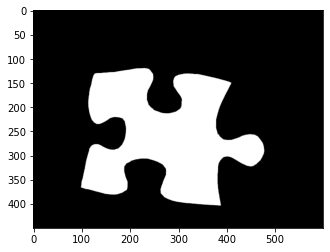

In [58]:
# display mask for comparison
plt.imshow(mask, cmap='gray')

Accuracy: 90.793704 percent
Confusion Matrix:
[[205873   3261]
 [ 21596  39270]]


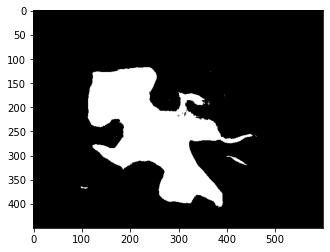

In [59]:
# test accuracy on training image
results = ss.multivariate_normal.pdf(hsv_img_with_textons, mean, cov, allow_singular=True)

theta = 0.01
predicted_mask = results < theta
predicted_mask = np.reshape(predicted_mask, (-1, 600))
plt.imshow(predicted_mask, cmap="gray")

correct = 0
incorrect = 0
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(np.shape(predicted_mask)[0]):
    for j in range(np.shape(predicted_mask)[1]):
        # in our mask, False indicates a background pixel
        if predicted_mask[i,j] == puzzle[i,j]:
            correct += 1
            if predicted_mask[i,j] == False:
                TP += 1
            else:
                TN += 1
        else:
            incorrect += 1
            if predicted_mask[i,j] == False:
                FP += 1
            else:
                FN += 1
                
accuracy_1 = correct / (results.shape[0]*results.shape[1]) * 100
print("Accuracy: %f percent" % accuracy_1)
confusion_matrix_1 = np.array([[TP, FN],
                            [FP, TN]])
print("Confusion Matrix:")
print(confusion_matrix_1)

We can see that the accuracy of the model slightly decreased. This is probably due to the massive number of features, even though 90% seems high, we can see from the predicted mask versus the actual mask that most of the correct predictions come from predicting with a bias towards the background. The actual shape of the puzzle piece is quite fuzzy.

5. Apply any other adjustments you think may be helpful for your model and report your final accuracy on test data. Remember to tune your hyper-parameters using validation data.

In [63]:
# choose to use grayscale intensities, RFS responses and Haar-like responses
# reshape grayscale to 2D, 1 channel
temp = np.empty([np.shape(gray_image)[0], np.shape(gray_image)[1], 1])
temp[:, :, 0] = gray_image
gray_image_3 = temp
img_features = gray_image_3
for res in img_RFS:
    img_features = np.concatenate((img_features, res), axis=2)
for res in img_haar:
    img_features = np.concatenate((img_features, res), axis=2)
print(img_features.shape)

(450, 600, 124)


In [64]:
# get background pixels
bkgrd_pixels = img_features[not_puzzle,:]
print(bkgrd_pixels.shape)

(209134, 124)


In [65]:
# train classifier
# i.e., calculate mean and covariance
mean = np.empty(124)
cov = np.zeros((124,124))

mean = np.mean(bkgrd_pixels, axis=0)
cov = np.cov(bkgrd_pixels.T)

print(mean.shape)
print(cov.shape)

(124,)
(124, 124)


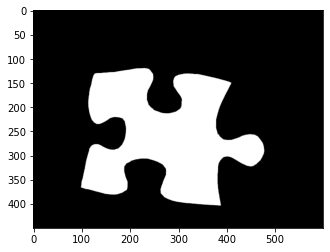

In [66]:
# display mask for comparison
plt.imshow(mask, cmap='gray')

Accuracy: 90.545185 percent
Confusion Matrix:
[[206414   2720]
 [ 22808  38058]]


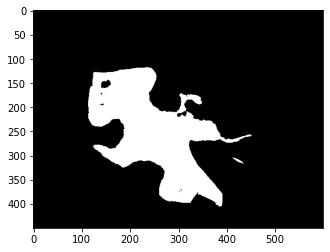

In [69]:
# test accuracy on training image
results = ss.multivariate_normal.pdf(img_features, mean, cov, allow_singular=True)

theta = 0.5
predicted_mask = results < theta
predicted_mask = np.reshape(predicted_mask, (-1, 600))
plt.imshow(predicted_mask, cmap="gray")

correct = 0
incorrect = 0
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(np.shape(predicted_mask)[0]):
    for j in range(np.shape(predicted_mask)[1]):
        # in our mask, False indicates a background pixel
        if predicted_mask[i,j] == puzzle[i,j]:
            correct += 1
            if predicted_mask[i,j] == False:
                TP += 1
            else:
                TN += 1
        else:
            incorrect += 1
            if predicted_mask[i,j] == False:
                FP += 1
            else:
                FN += 1
                
accuracy_1 = correct / (results.shape[0]*results.shape[1]) * 100
print("Accuracy: %f percent" % accuracy_1)
confusion_matrix_1 = np.array([[TP, FN],
                            [FP, TN]])
print("Confusion Matrix:")
print(confusion_matrix_1)

In [70]:
# predict on test image
test_image = images[2]
test_mask = masks[2]

gray_test = rgb2gray(test_image)

In [71]:
# apply to the image
img_RFS = []

for kernel in RFS:
    img_RFS.append(cv2.filter2D(test_image, -1, kernel))

In [72]:
# use cv2.filter2D for responses for later questions
img_haar = []
for i in range(len(size)):
    img_haar.append(cv2.filter2D(test_image, -1, K_haar[i]))

In [73]:
# choose to use grayscale intensities, RFS responses and Haar-like responses
# reshape grayscale to 2D, 1 channel
temp = np.empty([np.shape(gray_test)[0], np.shape(gray_test)[1], 1])
temp[:, :, 0] = gray_test
gray_image_3 = temp
img_features = gray_image_3
for res in img_RFS:
    img_features = np.concatenate((img_features, res), axis=2)
for res in img_haar:
    img_features = np.concatenate((img_features, res), axis=2)
print(img_features.shape)

(450, 600, 124)


In [74]:
# need to use mask to extract only pixels from background in image
gray_mask = rgb2gray(test_mask)
gray_mask = gray_mask*255

not_puzzle = gray_mask < 128
puzzle = gray_mask >= 128

# also convert mask to binary values
gray_mask[not_puzzle] = 0
gray_mask[puzzle] = 1

bkgrd_pixels = img_with_textons[not_puzzle,:]
print(bkgrd_pixels.shape)

(209619, 169)


Accuracy: 22.363333 percent
Confusion Matrix:
[[     0 209619]
 [     0  60381]]


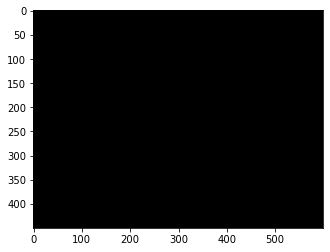

In [75]:
# test accuracy on training image
results = ss.multivariate_normal.pdf(img_features, mean, cov, allow_singular=True)

theta = 0.5
predicted_mask = results < theta
predicted_mask = np.reshape(predicted_mask, (-1, 600))
plt.imshow(predicted_mask, cmap="gray")

correct = 0
incorrect = 0
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(np.shape(predicted_mask)[0]):
    for j in range(np.shape(predicted_mask)[1]):
        # in our mask, False indicates a background pixel
        if predicted_mask[i,j] == puzzle[i,j]:
            correct += 1
            if predicted_mask[i,j] == False:
                TP += 1
            else:
                TN += 1
        else:
            incorrect += 1
            if predicted_mask[i,j] == False:
                FP += 1
            else:
                FN += 1
                
accuracy_1 = correct / (results.shape[0]*results.shape[1]) * 100
print("Accuracy: %f percent" % accuracy_1)
confusion_matrix_1 = np.array([[TP, FN],
                            [FP, TN]])
print("Confusion Matrix:")
print(confusion_matrix_1)